In [1]:
import pandas as pd
from datetime import datetime
import yfinance
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries


def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year - 2, end.month, end.day)
    data = yfinance.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    file_name=quote+".csv"
    df.to_csv(file_name)
    if df.empty:
        ts = TimeSeries(key="dj0yJmk9WVJxNlRuYlZ3TXVjJmQ9WVdrOU1HSTNaMDVFZUZrbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PWQ1", output_format="pandas")
        data= ts.get_daily_adjusted(symbol="NSE:" + quote, outputsize="full")
        data = data.head(503).iloc[::-1]
        data = data.reset_index()
        df = pd.DataFrame()
        df["Date"] = data["date"]
        df["Open"] = data["1. open"]
        df["High"] = data["2. high"]
        df["Low"] = data["3. low"]
        df["Close"] = data["4. close"]
        df["Adj Close"] = data["5. adjusted close"]
        df["Volume"] = data["6. volume"]
        file_name = quote + ".csv"
        df.to_csv(file_name, index=False)
    return file_name

In [5]:
nm = input()
print(nm)
file = get_historical(nm)
# df=pd.read_csv(file)
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
data = pd.read_csv(file, sep=',', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
plt.figure(figsize=(5,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'])

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.describe()


,Open,High,Low,Close,Adj Close,Volume
count,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02
mean,164.891253,166.685746,163.257038,165.071630,164.147398,7.052219e+07
std,18.695549,18.371317,18.924660,18.663107,18.942683,2.440712e+07
min,126.010002,127.769997,124.169998,125.019997,124.166641,2.404830e+07
25%,148.884995,150.930000,147.264999,149.375000,148.143005,5.246465e+07
50%,165.509995,167.410004,164.309998,165.809998,164.494308,6.579930e+07
75%,180.379997,182.079994,178.440002,180.640007,180.048973,8.202575e+07
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.826020e+08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


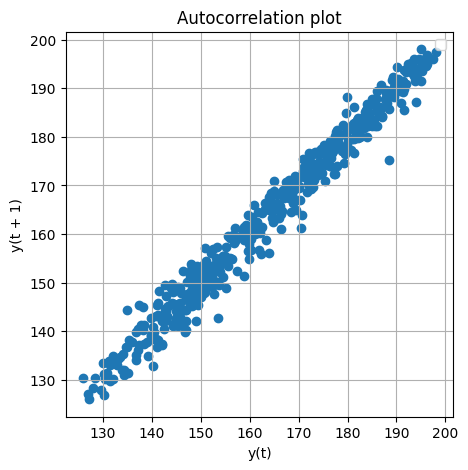

In [4]:
import pandas as pd
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(data['Open'], lag=1)
plt.title('Autocorrelation plot')
plt.grid(True)
plt.legend()


values = pd.DataFrame(data['Open'].values)
dataframe = pd.concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
# print(result)

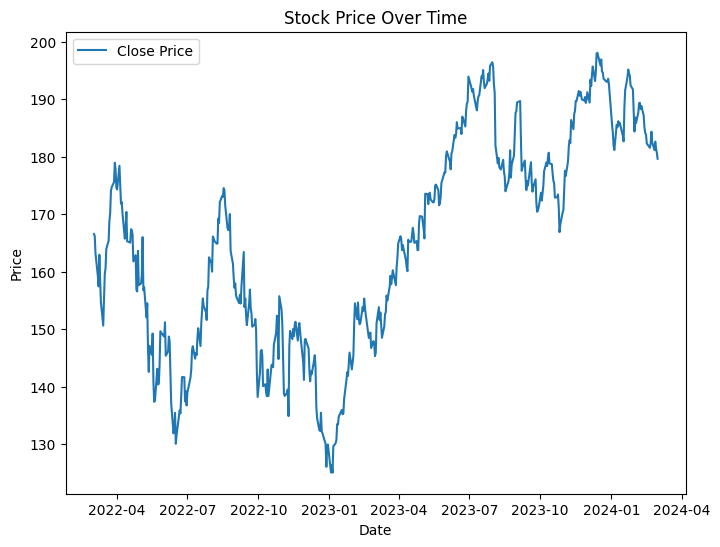

In [5]:
plt.figure(figsize=(8,6))
plt.plot(data['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Over Time')
plt.legend()
plt.show()

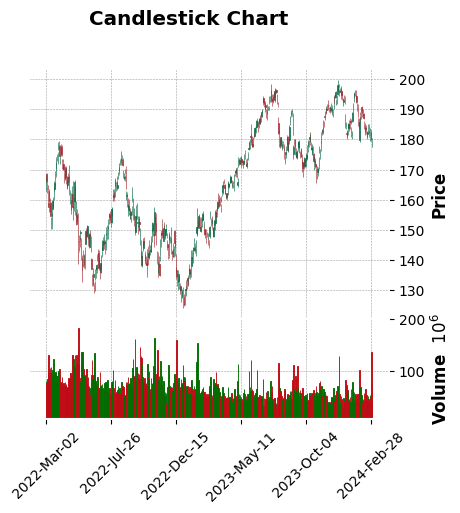

In [6]:
import mplfinance as mpf
mpf.plot(data, type='candle',
        style='charles',
        title='Candlestick Chart',
        volume=True, figsize=(5,5)
        )

In [7]:
#splitting the data into 70% training and 30% testing
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
# plt.figure(figsize=(5,5))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('Open Prices')
# plt.plot(data['Open'], 'green', label='Train data')
# plt.plot(test_data['Open'], 'blue', label='Test data')
# plt.legend()

In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# preprocessing training data
train = train_data.iloc[:, 0:1].values 
scaler = MinMaxScaler() 
train_scaled = scaler.fit_transform(train)
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) 
    y_train.append(train_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #Reshaping
from numpy.random import seed 
seed(2019)

In [9]:
#preprocessing testing data
test = test_data.iloc[:, 0:1].values 
scaler = MinMaxScaler() 
test_scaled = scaler.fit_transform(test)
timesteps = 7
X_test = []
y_test = []
for i in range(timesteps, test.shape[0]):
    X_test.append(test_scaled[i-timesteps:i, 0]) 
    y_test.append(test_scaled[i, 0]) 
X_test, y_test = np.array(X_test), np.array(y_test)

GRU

In [10]:
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.25))

model.add(GRU(units=50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.25))

model.add(Dense(units=1, activation='linear'))

In [11]:
optimizer = Adam(learning_rate=0.001)

In [12]:
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [13]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50

12/12 [==============================] - 13s 233ms/step - loss: 0.0721 - val_loss: 0.0193
Epoch 2/50
12/12 [==============================] - 0s 27ms/step - loss: 0.0232 - val_loss: 0.0048
Epoch 3/50
12/12 [==============================] - 0s 35ms/step - loss: 0.0129 - val_loss: 0.0249
Epoch 4/50
12/12 [==============================] - 0s 41ms/step - loss: 0.0119 - val_loss: 0.0057
Epoch 5/50
12/12 [==============================] - 0s 35ms/step - loss: 0.0101 - val_loss: 0.0042
Epoch 6/50
12/12 [==============================] - 0s 26ms/step - loss: 0.0100 - val_loss: 0.0046
Epoch 7/50
12/12 [==============================] - 0s 26ms/step - loss: 0.0090 - val_loss: 0.0065
Epoch 8/50
12/12 [==============================] - 0s 25ms/step - loss: 0.0090 - val_loss: 0.0103
Epoch 9/50
12/12 [==============================] - 0s 26ms/step - loss: 0.0104 - val_loss: 0.0074
Epoch 10/50
12/12 [==============================] - 0s 24ms/step - loss: 0.0091 - val_loss: 0.0062
Epoch 

2/2 [==============================] - 2s 7ms/step
predicted stock price for tomorrow:  [182.38562]


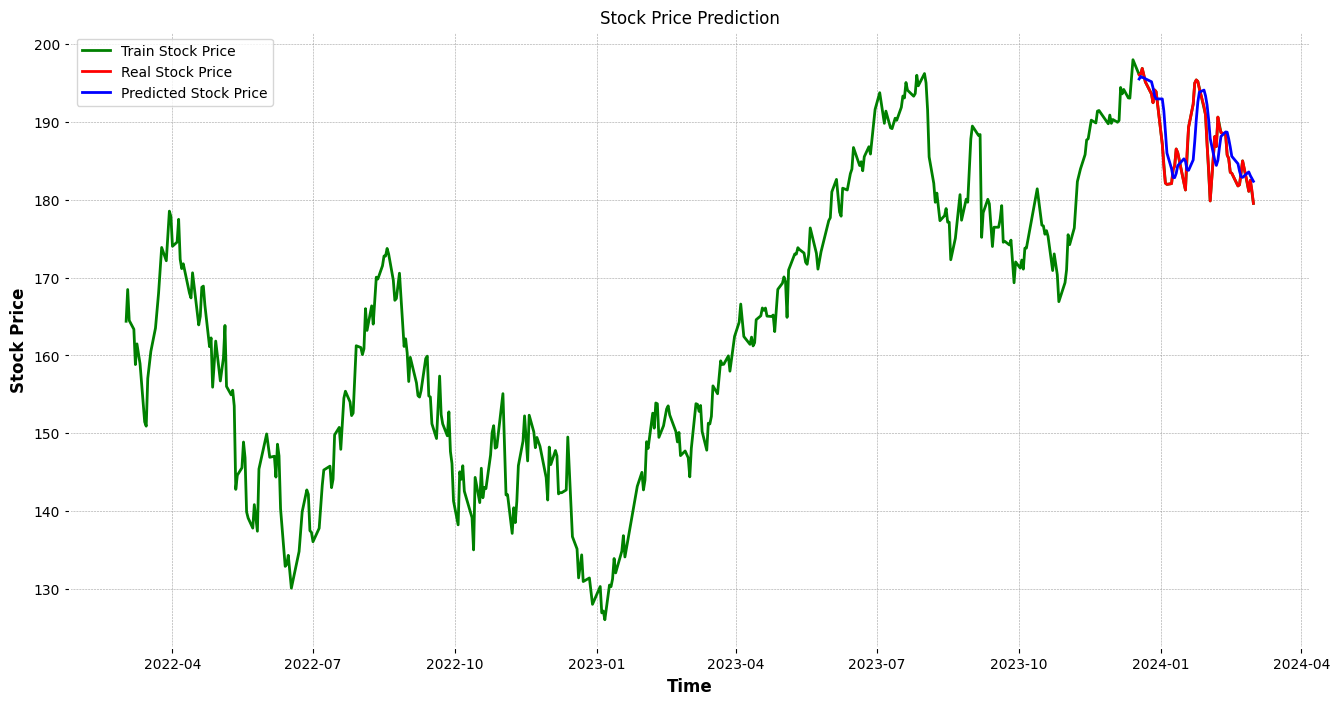

In [14]:
real_stock_price = test_data.iloc[:,0:1].values
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)

test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
#print(predicted_stock_price)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
print("predicted stock price for tomorrow: ",predicted_stock_price[len(predicted_stock_price)-1])

plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

mse13 = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse13))
mae13 = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae13))
rmse13 = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse13))
r213 = r2_score(real_stock_price, predicted_stock_price)
print('R2 Score: ' + str(r213))

MSE: 12.452312907724458
MAE: 2.8154171214384167
RMSE: 3.5287834883603244
R2 Score: 0.5474046820259484
